In [2]:
import os
import sys
import glob

import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.backend.tensorflow_backend import set_session

import matplotlib.pyplot as plt

import nibabel as nib

Using TensorFlow backend.


In [3]:
def plot(img):
    plt.figure()
    plt.imshow(img[:, 16, :], cmap='gray')
    
def load_nii(path):
    nii = nib.load(path)
    vol = nii.get_data().astype(np.float32)
    return np.squeeze(vol)

In [4]:
run_dirs = glob.glob('../runs/*/predict')
run_dirs = sorted(run_dirs)

print('found {} runs'.format(len(run_dirs)), '\n')

for i, run in enumerate(run_dirs):
    print(i, run, '\n')

found 3 runs 

0 ../runs/gan_20190428_1448_gpu=7_bs=4_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=50.0_vr=0.5_is=5_cs=5_rf=10_rs=5_sw=True_glw=[1_100_500_10_0]_clw=[1_1_10]/predict 

1 ../runs/gan_20190430_1720_gpu=7_bs=16_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=50.0_lk=0.2_bn=True_vr=0.5_is=6_cs=5_rf=10_rs=5_sw=True_glw=[1_100_500_10_0_0]_clw=[1_1_10]_tag=beefier_decoder_more_summaries_batchnorm/predict 

2 ../runs/gan_20190503_1139_gpu=2_bs=16_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=25.0_lk=0.2_bn=True_vr=0.5_is=6_cs=5_rf=10_rs=5_sw=True_reg=True_clf=False_glw=[1.0_500.0_10.0_250.0_0.0_0.0_50.0]_clw=[1.0_1.0_10.0]_tag=new_arch/predict 



In [5]:
# set run dir
run_dir = run_dirs[2]

pre_dirs = glob.glob(os.path.join(glob.escape(run_dir), '*', '*'))
pre_dirs = sorted(pre_dirs)

print('found {} pre_dirs'.format(len(pre_dirs)))

for i, pre_dir in enumerate(pre_dirs):
    #print(i, os.path.basename(pre_dir))
    print(i, pre_dir.split('/')[-2] + '/' + pre_dir.split('/')[-1])

found 5 pre_dirs
0 eval/gen_060
1 eval/gen_060_04
2 eval/gen_250_04
3 test/gen_060_04
4 test/gen_250_04


In [6]:
# generator config, run_dir, etc...
pre_dir = pre_dirs[2]

csv_path = os.path.join(pre_dir, 'meta.csv')
csv = pd.read_csv(csv_path)

print('found meta.csv: {}'.format(csv.shape))

print(csv.columns)

found meta.csv: (2408, 43)
Index(['source_0', 'pat_id', 'pat_age_0', 'pat_dx_0', 'examdate_0', 'field_0',
       'img_id_0', 'img_shape_0', 'img_path_0', 'mfg_0', 'mfg_model_0',
       'timestamp_0', 'split', 'pMCI_0', 'sMCI_0', 'MCI_0', 'AD_0',
       'n_visits_0', 'split_reg', 'source_1', 'pat_age_1', 'pat_dx_1',
       'examdate_1', 'field_1', 'img_id_1', 'img_shape_1', 'img_path_1',
       'mfg_1', 'mfg_model_1', 'timestamp_1', 'pMCI_1', 'sMCI_1', 'MCI_1',
       'AD_1', 'n_visits_1', 'delta_t', 'split_clf', 'weight', 'delta_t_real',
       'img_path_yf', 'img_path_flow_params', 'img_path_flow', 'Df'],
      dtype='object')


In [13]:
def load_nii(path):
    
    nii = nib.load(path)
    vol = np.squeeze(nii.get_data().astype(np.float32))
    
    return vol

In [ ]:
flow_vols = [[], [], []]
dist_vols = [[], [], []]
yhat_vols = [[], [], []]

for i, row in csv.iloc[:].iterrows():
    
    dx = int(row['pat_dx_1'])
    
    flow_vols[dx-1].append(row['img_path_flow'])
    dist_vols[dx-1].append(row['img_path_flow_params'])
    yhat_vols[.append(row['img_path_yf'])

mean: 0.13312235474586487, 0.11498642712831497
std: 0.011975555680692196, 0.002306429436430335
div: 0.6198209524154663, 0.7789628505706787
mean: 0.11917321383953094, 0.10352747142314911
std: 0.01205832976847887, 0.002312252763658762
div: 0.6487333178520203, 0.7917727828025818
mean: 0.12386703491210938, 0.10799873620271683
std: 0.011970531195402145, 0.0022317063994705677
div: 0.6460146903991699, 0.7918676733970642


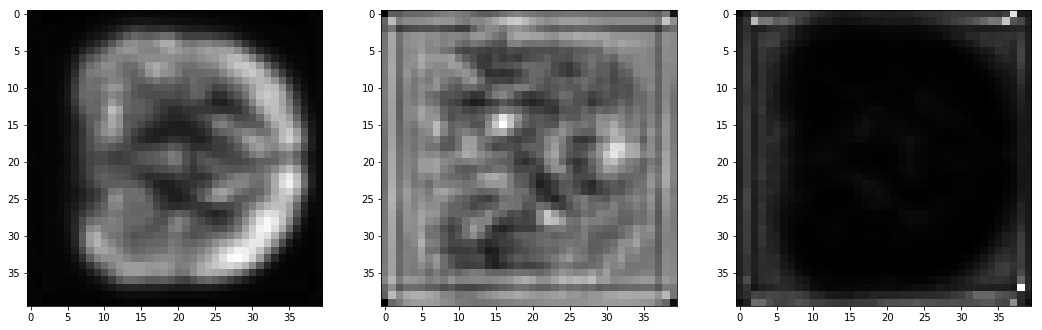

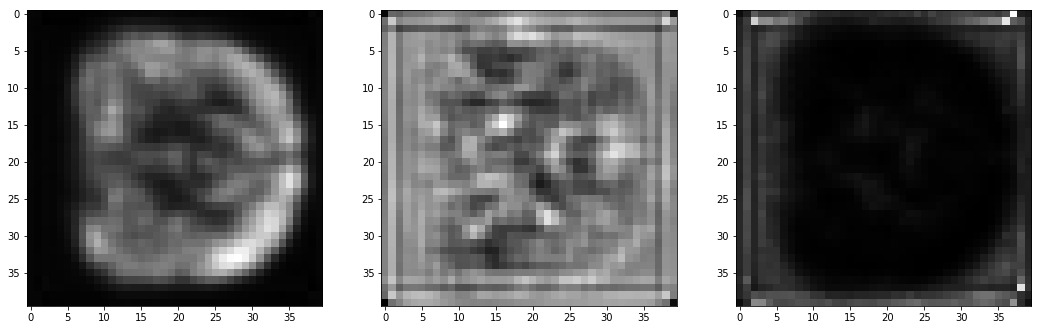

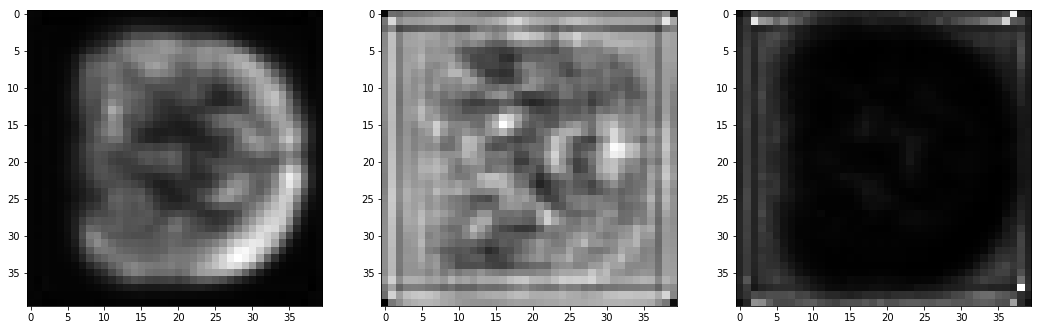

In [9]:
# flow_params
# magnitude of mean, magnitude of std, mag_std / mag_mean
flow_means = [[],[],[]]
flow_stds = [[],[],[]]
flow_divs = [[],[],[]]

for i, row in csv.iloc[:].iterrows():
    
    flow = load_nii(row['img_path_flow_params'])
    
    flow_mean = flow[..., :3]
    mag_mean = np.sqrt((flow_mean * flow_mean).sum(axis=-1))
    
    flow_std = flow[..., 3:]
    flow_std = np.exp(flow_std)
    mag_std = np.sqrt((flow_std * flow_std).sum(axis=-1))
    
    mag_div = mag_std / mag_mean
    
    dx = int(row['pat_dx_1'])
        
    flow_means[dx-1].append(mag_mean)
    flow_stds[dx-1].append(mag_std)
    flow_divs[dx-1].append(mag_div)
    
for mean_dx, std_dx, div_dx in zip(flow_means, flow_stds, flow_divs):
    mean = np.array(mean_dx).mean(axis=0)
    std = np.array(std_dx).mean(axis=0)
    div = np.array(div_dx).mean(axis=0)

    print('mean: {}, {}'.format(mean.mean(), mean.std()))
    print('std: {}, {}'.format(std.mean(), std.std()))
    print('div: {}, {}'.format(div.mean(), div.std()))
    
    plt.figure(figsize=(18, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(mean[:, 8, :], cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(std[:, 8, :], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(div[:, 8, :], cmap='gray')

0.42537937 0.22857644
norm: 0.16679344 0.08806709
0.39341027 0.20219347
norm: 0.16467081 0.08336954
0.40543374 0.21285468
norm: 0.16695663 0.08550409


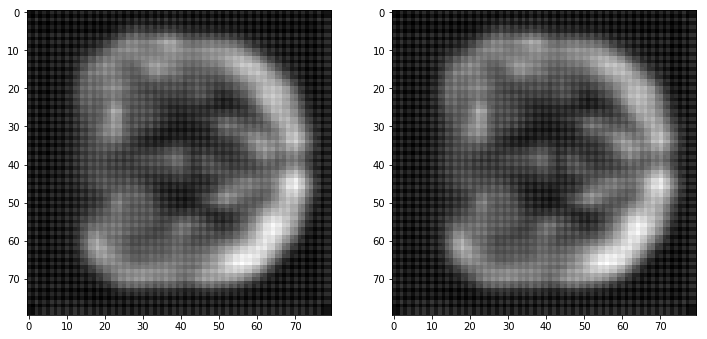

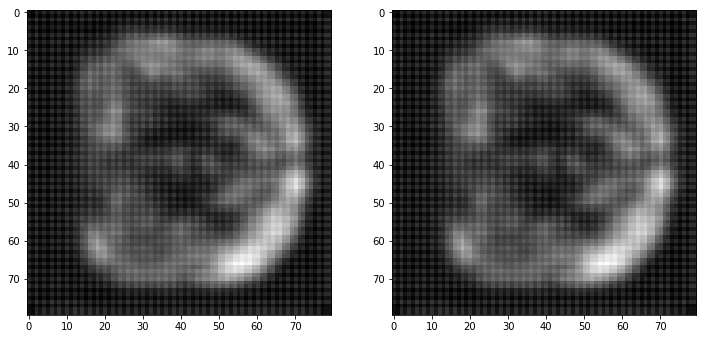

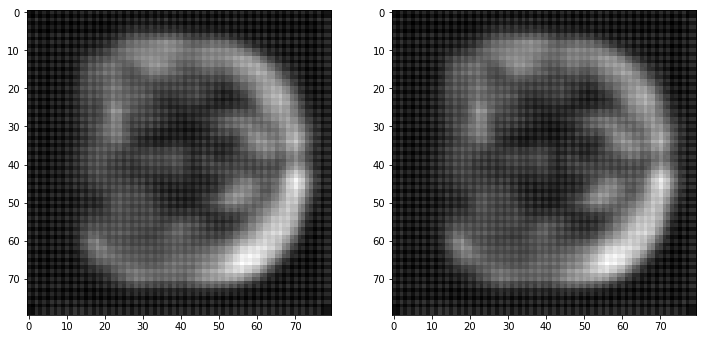

In [8]:
# flow
# magnitude, magnitude normalized
flows = [[],[],[]]
flows_norm = [[],[],[]]

for i, row in csv.iloc[:].iterrows():

    dx = int(row['pat_dx_1'])
    
    flow = load_nii(row['img_path_flow'])
    mag = np.sqrt((flow * flow).sum(axis=-1))
    
    flows[dx-1].append(mag)
    
    max_v = flow.max()
    max_v = 1 if max_v == 0 else max_v
    
    mag_norm = mag / max_v
    
    flows_norm[dx-1].append(mag_norm)
    
for flow_dx, flow_norm_dx in zip(flows, flows_norm):
    mean = np.array(flow_dx).mean(axis=0)
    mean_norm = np.array(flow_norm_dx).mean(axis=0)

    print(mean.mean(), mean.std())
    print('norm:', mean_norm.mean(), mean_norm.std())
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(mean[:, 16, :], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(mean_norm[:, 16, :], cmap='gray')

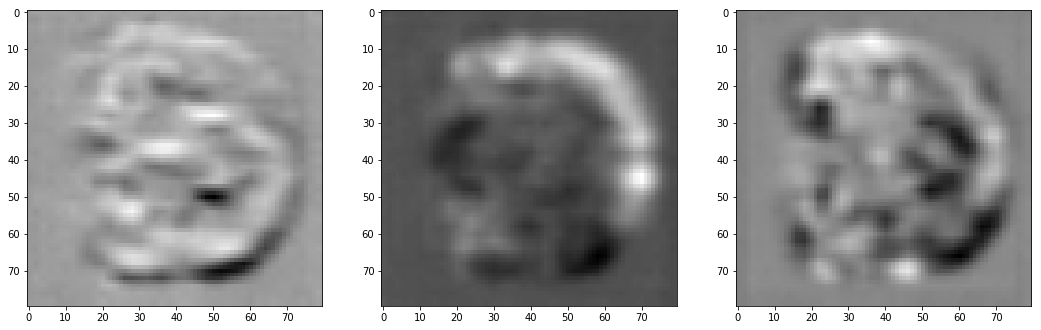

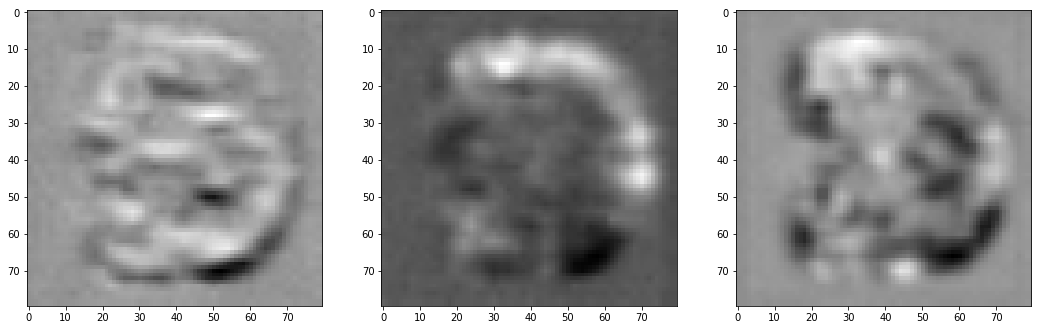

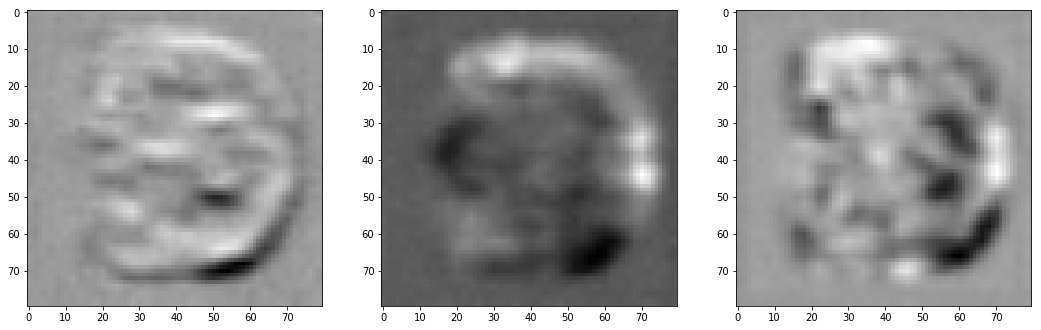

In [9]:
# flow
# dimensions
flows = [[],[],[]]

for i, row in csv.iloc[:].iterrows():
    
    flow = load_nii(row['img_path_flow'])
    
    dx = int(row['pat_dx_1'])
    
    flows[dx-1].append(flow)
    
for flow_dx in flows:
    mean = np.array(flow_dx).mean(axis=0)

    plt.figure(figsize=(18, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(mean[:, 16, :, 0], cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(mean[:, 16, :, 1], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(mean[:, 16, :, 2], cmap='gray')

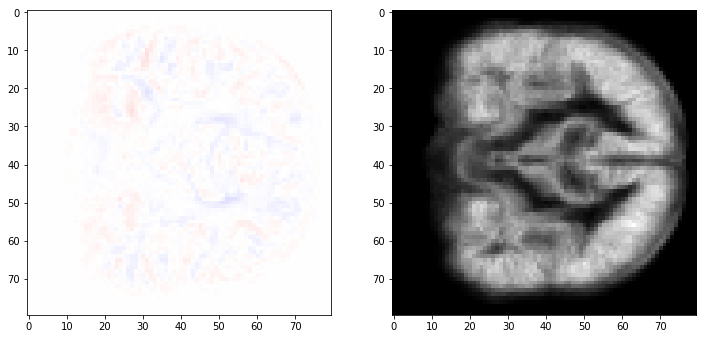

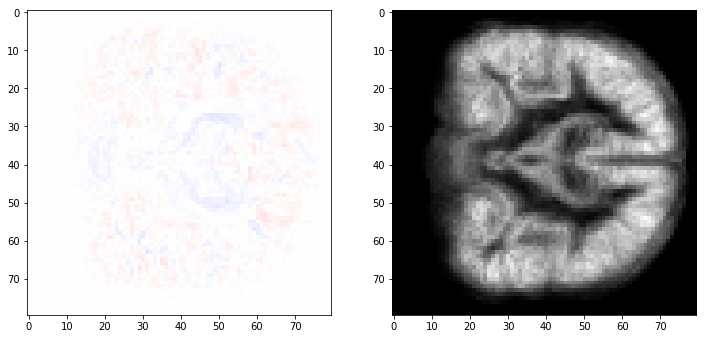

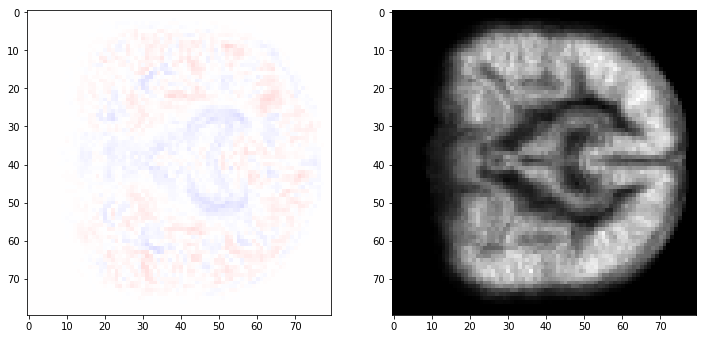

In [12]:
# x_real, y_real (delta not fixed!)
# difference
diffs = [[],[],[]]

for i, row in csv.iloc[:].iterrows():
    
    xr = load_nii(row['img_path_0'])
    yr = load_nii(row['img_path_1'])
    
    diff = yr - xr
    
    dx = int(row['pat_dx_1'])
    
    diffs[dx-1].append(diff)
    
for diff_dx in diffs:
    mean = np.array(diff_dx).mean(axis=0)
    mean_abs = np.abs(np.array(diff_dx)).mean(axis=0)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(mean[:, 16, :], cmap='bwr', vmin=-1, vmax=1)
    plt.subplot(1, 2, 2)
    plt.imshow(mean_abs[:, 16, :], cmap='gray')

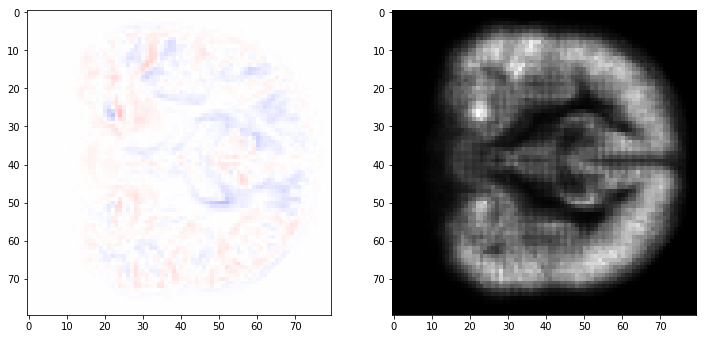

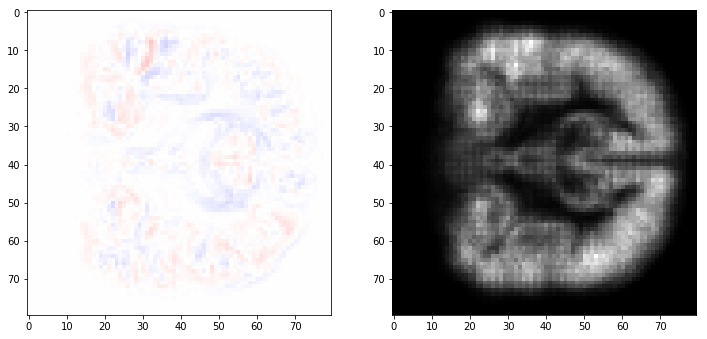

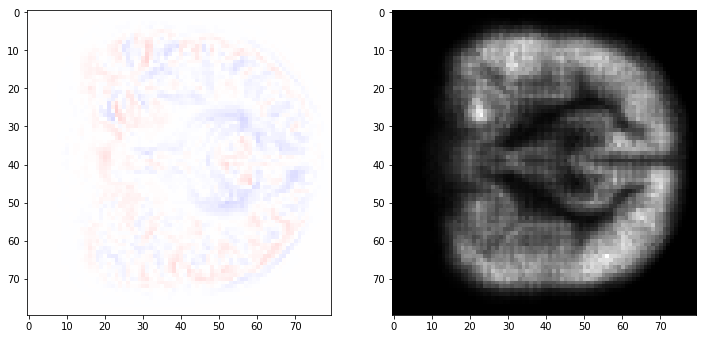

In [11]:
# x_real, y_fake
# difference
diffs = [[],[],[]]

for i, row in csv.iloc[:].iterrows():
    
    xr = load_nii(row['img_path_0'])
    yf = load_nii(row['img_path_yf'])
    
    diff = yf - xr
    
    dx = int(row['pat_dx_1'])
    
    diffs[dx-1].append(diff)
    
for diff_dx in diffs:
    mean = np.array(diff_dx).mean(axis=0)
    mean_abs = np.abs(np.array(diff_dx)).mean(axis=0)

    plt.figure(figsize=(12, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(mean[:, 16, :], cmap='bwr', vmin=-1, vmax=1)
    plt.subplot(1, 2, 2)
    plt.imshow(mean_abs[:, 16, :], cmap='gray')